In [1]:
! pip install simpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import simpy
import numpy as np
import pandas as pd

In [69]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(np.random.exponential(servicetime))

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings



In [72]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.066304   
1             2  0.10          1.008887   
2             4  0.10          1.019525   
3             1  0.50          1.888235   
4             2  0.50          1.275676   
5             4  0.50          1.069359   
6             1  0.90          5.162061   
7             2  0.90          3.472780   
8             4  0.90          2.432713   
9             1  0.99          6.358474   
10            2  0.99          5.368592   
11            4  0.99          3.752229   

                                     all_waiting_time  \
0   [[0.03298680115865616, 1.3263568623573097, 0.8...   
1   [[1.3161148540566983, 0.7212206668650625, 0.88...   
2   [[0.11140072613845894, 0.49443260751867735, 0....   
3   [[1.4061927549947686, 0.5912884128358744, 0.35...   
4   [[0.8739091424852079, 0.14586119123873265, 2.0...   
5   [[0.2517315677566173, 0.048719931624338964, 0....   
6   [[0.020518884751140307, 0.04727195873

In [121]:
def run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

def plot_data(df):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title('Comparison of Average Waiting Time by System Load')
    plt.xlabel('System Load (rho)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


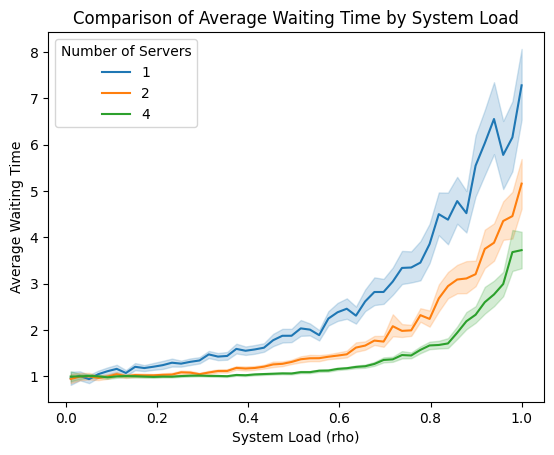

In [122]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


In [61]:
print(all_sim_data[0]['all_waiting_time'][1])

[0.04932574559630233, 0.8164974332294359, 2.4665221464109006, 1.7418097225314426, 0.4031369130262803, 0.9541658896937548, 2.415697707669878, 0.3003988927243455, 3.018267933580759, 0.12147752825026714, 0.6221153232973649, 0.7548075423427036, 0.7865639889521248, 1.6272287764519575, 1.2605978732157155, 1.774842137810495]


In [131]:
# 绘制直方图或密度图
def plt_distribution(all_sim_data, title, xlabel = 'Waiting Time'):
#     print(len(all_sim_data))
#     sns.histplot(all_sim_data, kde=True, element='step', stat='density', bins=200)
    sns.histplot(all_sim_data, kde=True, stat='density', bins=200)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()
    
# # 旧的绘制叠加的直方图或密度图
# def plt_distribution_group(sim_data_group, title, labels, xlabel = 'Waiting Time'):
# #     print(len(all_sim_data))
#     for group_data in sim_data_group:
#         sns.histplot(group_data, kde=True, stat='density', bins=200)
# #         sns.histplot(group_data, kde=True, element='step', stat='density', bins=200)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Density')
#     plt.legend(labels=labels)
#     plt.show()
    
# # 绘制叠加的直方图或密度图
# def plot_distribution_group(sim_data_group, title, labels, xlabel='Waiting Time'):
#     for group_data, label in zip(sim_data_group, labels):
#         sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Density')
#     plt.legend()
#     plt.show()

# 绘制叠加的直方图或密度图
def plt_distribution_group(sim_data_group, title, labels, xlabel='Average Waiting Time'):
    for group_data, label in zip(sim_data_group, labels):
        sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def prepare_group_data(sim_data):
    # 将模拟结果中的所有等待时间整理到一个列表中
    all_waiting_times = []
    for data in sim_data:
        all_waiting_times.extend(data)

    return all_waiting_times


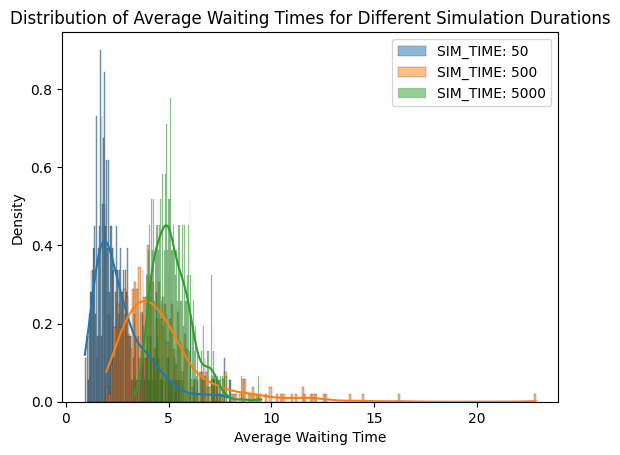

In [132]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = 500  # 模拟次数
SIM_TIMES = [50, 500, 5000]  # 不同的模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIM_TIME in SIM_TIMES:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'SIM_TIME: {SIM_TIME}' for SIM_TIME in SIM_TIMES]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


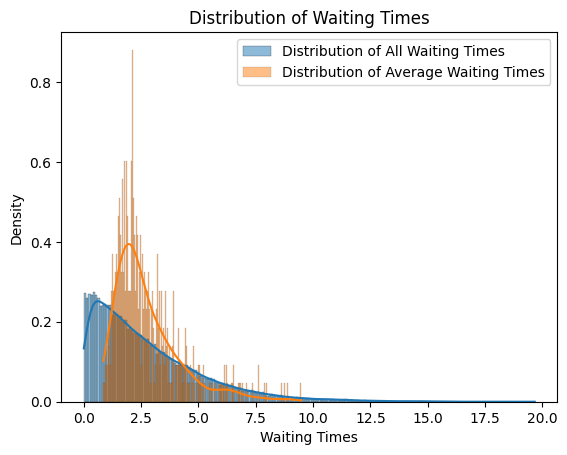

In [133]:
# Simulation parameters
num_servers = 2
rho = 0.9  # System load
MU = 1  # Service rate
SIM_TIME = 50  # Simulation duration
SIMULATIONS = 500  # Number of simulations


sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual

all_waiting_times = []
for data in sim_data:
    all_waiting_times.extend(data)

# plt_distribution(all_waiting_times, 'Distribution of All Waiting Times')
# plt_distribution(avg_waitings, 'Distribution of Average Waiting Times')
group_data = [all_waiting_times, avg_waitings]
labels = ['Distribution of All Waiting Times', 'Distribution of Average Waiting Times']
plt_distribution_group(group_data, "Distribution of Waiting Times", labels, "Waiting Times")

### 不用的代码

In [ ]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 定义队列类
class Queue:
    def __init__(self, env, num_servers, servicetime):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.servicetime = servicetime

    def service(self, customer):
        """服务过程使用指数分布的服务时间"""
        yield self.env.timeout(np.random.exponential(self.servicetime))

# 定义顾客到达过程
def customer(env, name, qu):
    arrival_time = env.now
    with qu.server.request() as request:
        yield request
        yield env.process(qu.service(name))
        waiting_time = env.now - arrival_time
        # 记录每个顾客的等待时间
        qu.env.waiting_times.append(waiting_time)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda):
    queue = Queue(env, num_servers, servicetime)
    queue.env.waiting_times = []
    # 生成初始顾客
    env.process(customer(env, 'Customer 0', queue))
    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(env, f'Customer {env.now}', queue))

# 运行模拟函数
def run_simulation(num_servers, Lambda, servicetime, SIM_TIME, SIMULATIONS):
    data_sims = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        env.process(setup(env, num_servers, servicetime, Lambda))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(env.waiting_times)
        data_sims.append(avg_waiting)
    return data_sims

# 模拟参数
MU = 1  # the capacity of each of n equal servers
SIM_TIME = 100
SIMULATIONS = 100
SERVERS = [1, 2, 4]  # 服务器数量n
RHO = [0.5, 0.9, 0.99]  # the system load, RHO = Lambda / (MU * n)

# 存储所有模拟的结果
all_sim_data = []

# 对每个服务器数量n和系统负载ρ运行模拟
for num_servers in SERVERS:
    for rho in RHO:
        Lambda = rho * (MU * num_servers)  # the arrival rate into the system as a whole
        sim_data = run_simulation(num_servers, Lambda, 1/MU, SIM_TIME, SIMULATIONS)
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(sim_data),
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(sim_data), scale=stats.sem(sim_data))
        })

# 将结果转换为DataFrame并保存为CSV文件
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


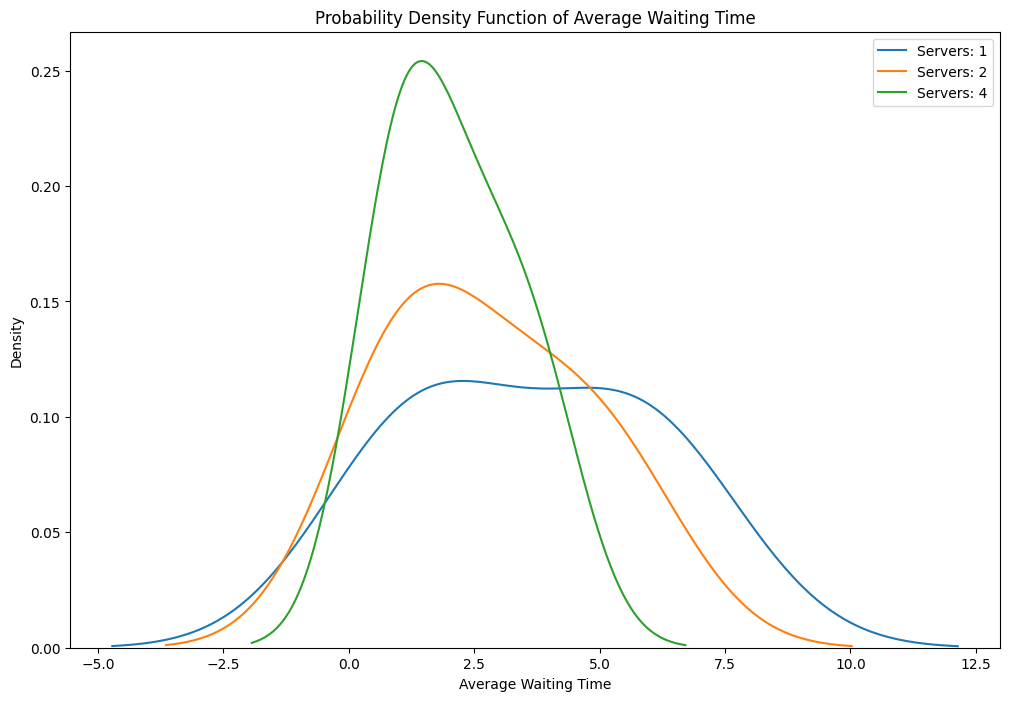

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设all_sim_data已经根据上述代码生成并转换为DataFrame
df = pd.DataFrame(all_sim_data)

# 绘制每个ρ值和服务器数量的平均等待时间的概率密度函数
plt.figure(figsize=(12, 8))

for num_servers in SERVERS:
    subset = df[df['num_servers'] == num_servers]
    sns.kdeplot(subset['avg_waiting_time'], label=f'Servers: {num_servers}')

plt.title('Probability Density Function of Average Waiting Time')
plt.xlabel('Average Waiting Time')
plt.ylabel('Density')
plt.legend()
plt.show()